##To do:
1. Make grid search
2. Test balanced and unbalanced dataset
3. CNN-LIN
4. RNN/LSTM
5. MDN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

# Data processing
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.blocks import StdLinear, DenseBlock
from utils.clr import *
from collections import OrderedDict

In [2]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Model vars
bs = 1                        # 1 for linbench
md = False

True


## Data Injest

In [3]:
DATAPATH = Path.cwd() / 'data'

In [4]:
def moving_mean(time, data, lag=5):
    X = []
    y = []
    y_std = []
    for i in range(int(len(data)/lag)):
        X.append(time[(i*lag+lag)])
        y.append(np.mean(data[(i*lag):(i*lag+lag)]))
        y_std.append(np.std(data[(i*lag):(i*lag+lag)]))
        
    return X, y, y_std

In [5]:
# df = pd.read_csv(DATAPATH / 'dual_sen_sample_1.csv',parse_dates=['datetime','date'])

# df.drop(['date','time','r_sen_1','s_sen_1','s_sen_2'],axis=1,inplace=True)
# # df["mvg20_sen_2"] = df.loc[:,"r_sen_2"].rolling(window=20).mean()
# # df["mvg20_sen_2"] = df["mvg20_sen_2"].round()
# df['r_sen_2'] = (df['r_sen_2'] - 630)*-1
# x, y, y_err = moving_mean(df['datetime'],df["r_sen_2"], 10)
# df.loc[df['datetime'].isin(x),'avg_sen_2'] = y
# df.loc[df['datetime'].isin(x),'std_sen_2'] = y_err
# df.dropna(inplace=True)
# df.reset_index(inplace=True)
# df.drop('index',axis=1,inplace=True)

# df.to_feather(DATAPATH / 'sen_aggre.feather')
# df.head()
df = pd.read_feather(DATAPATH / 'sen_aggre.feather')

## Data visual

In [6]:
df_w = df.loc[df['std_sen_2'] > 15]
df_t = pd.DataFrame(data={'datetime':pd.to_datetime("2020-08-07 13:40:31"),'r_sen_2':np.average(df_w['r_sen_2']), 'avg_sen_2':np.average(df_w['avg_sen_2']),'std_sen_2':np.average(df_w['std_sen_2'])},index=[0])
df_t = df_t.append(df_w)
df_t.sort_values(['datetime'],ascending=False,inplace=True)


for r_i, r_d in df.iterrows():
    for idx, row in df_t.iterrows():
        if r_d.datetime >= row.datetime:
            df.loc[r_i,'last_water'] = r_d.datetime - row.datetime
            break
        else:
            next

df['dow'] = df.datetime.dt.dayofweek
df.reset_index(inplace=True)
df.index = df.datetime
df.drop("datetime",axis=1,inplace=True)
df.dropna(inplace=True)
df_w

,datetime,r_sen_2,avg_sen_2,std_sen_2
597,2020-08-16 18:28:31,202,112.6,113.558091
2152,2020-08-27 13:27:31,154,184.0,23.383755
3572,2020-09-06 10:01:53,210,113.6,114.248151
4738,2020-09-14 12:13:49,251,29.9,89.700000


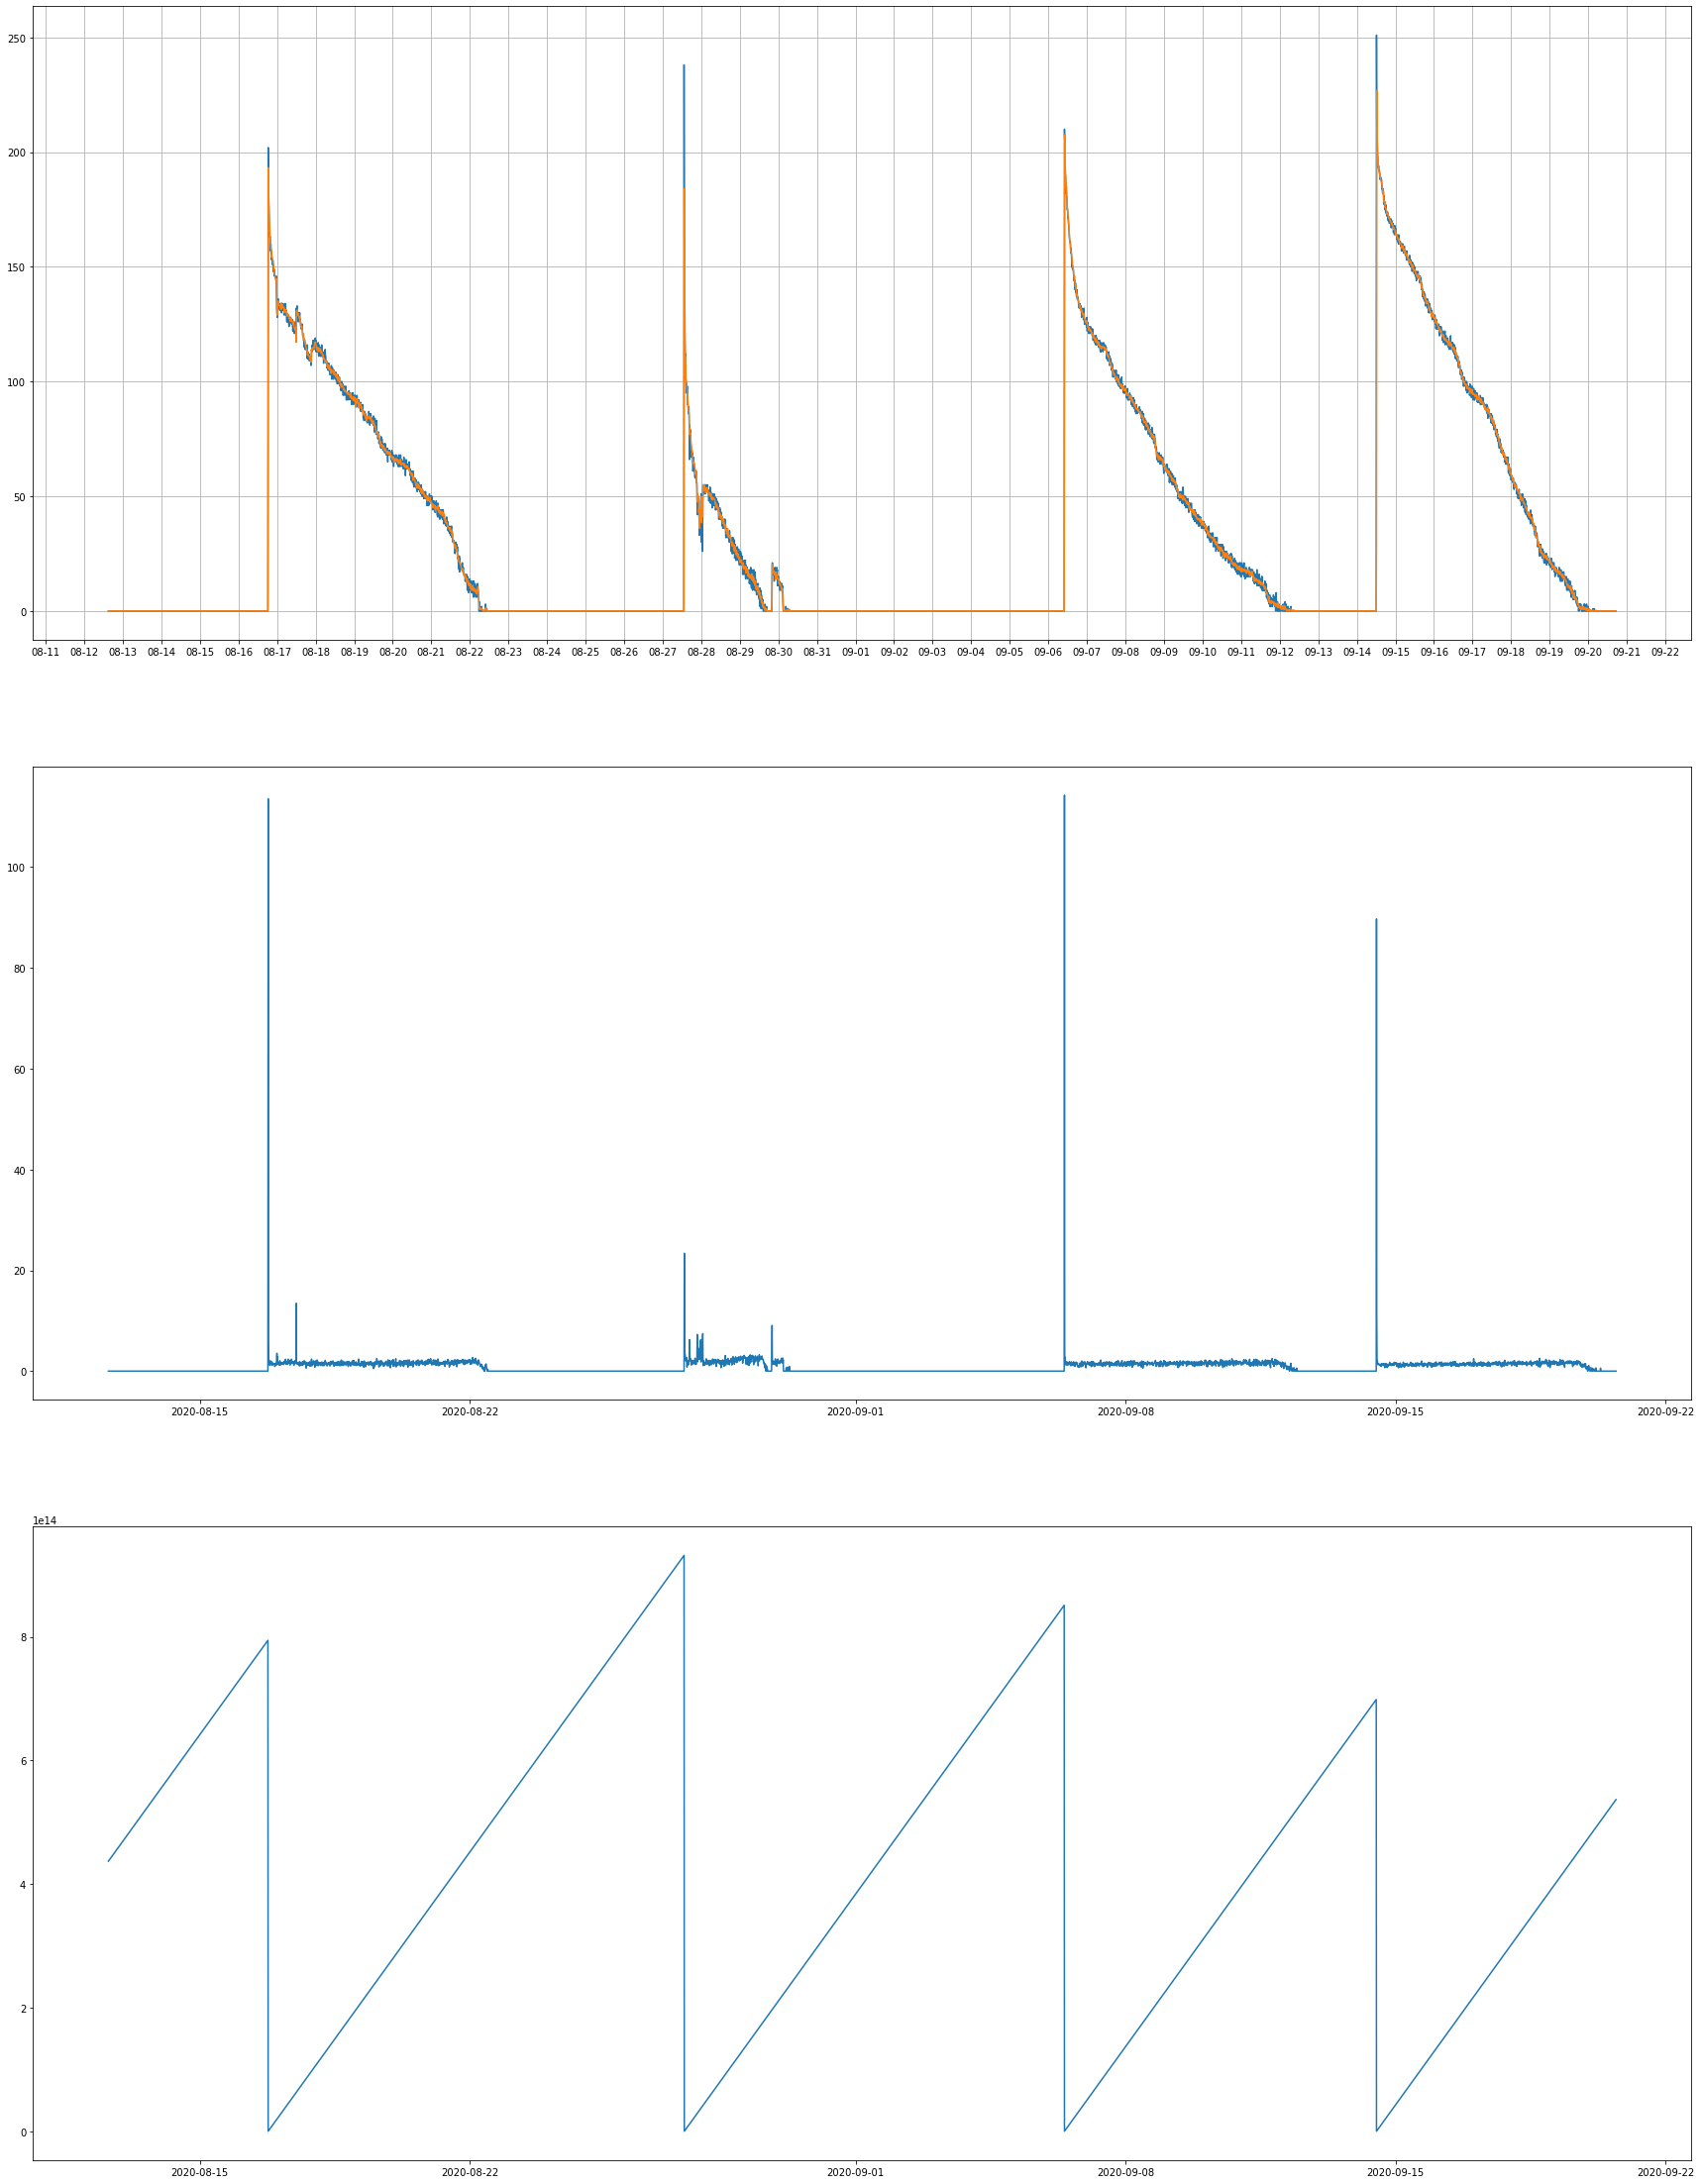

In [7]:
df_ts = df.copy()

fig, ax = plt.subplots(3,figsize=[30,40])
ax[0].grid(True)
ax[0].plot(df_ts.loc[:,'r_sen_2'],label='data')
ax[0].plot(df_ts.loc[:,'avg_sen_2'],label='avgd')
ax[0].xaxis.set_major_locator(mdates.DayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax[1].plot(df_ts['std_sen_2'])
ax[2].plot(df_ts['last_water'])
plt.show()

/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


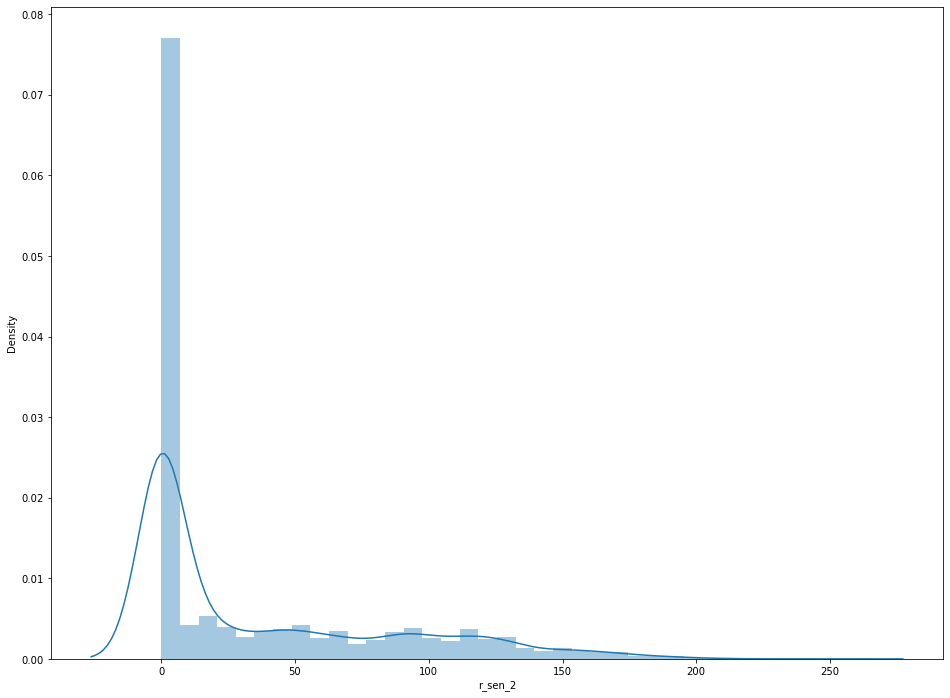

In [8]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df['r_sen_2'], hist=True,ax=ax)
plt.show()

In [9]:
df_t = df.loc[df['std_sen_2'] == 0,:]
df_p = df_t.iloc[::75]
# df_p = df_t.loc[df_t['std_sen_2'].isin(df_p.loc[:,'std_sen_2']),:]
df_t = df.loc[df['std_sen_2'] > 0, :]

df_d = df_p.append(df_t)
df_d.sort_index(inplace=True)
print(len(df))
print(len(df_d))

5634
2889


In [10]:
print(len(df_t))
print(len(df_p))

2851
38


In [11]:
df_d = df_d.reset_index()
df_d.drop(['index'],axis=1,inplace=True)
df_d.to_csv(DATAPATH / 'sen_aggre2.csv')

In [12]:
df_d.head()

,datetime,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,2020-08-12 15:02:11,0,0.0,0.0,5 days 01:21:40,2
1,2020-08-13 03:31:27,0,0.0,0.0,5 days 13:50:56,3
2,2020-08-13 16:01:27,0,0.0,0.0,6 days 02:20:56,3
3,2020-08-14 04:30:43,0,0.0,0.0,6 days 14:50:12,4
4,2020-08-14 16:59:59,0,0.0,0.0,7 days 03:19:28,4


/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


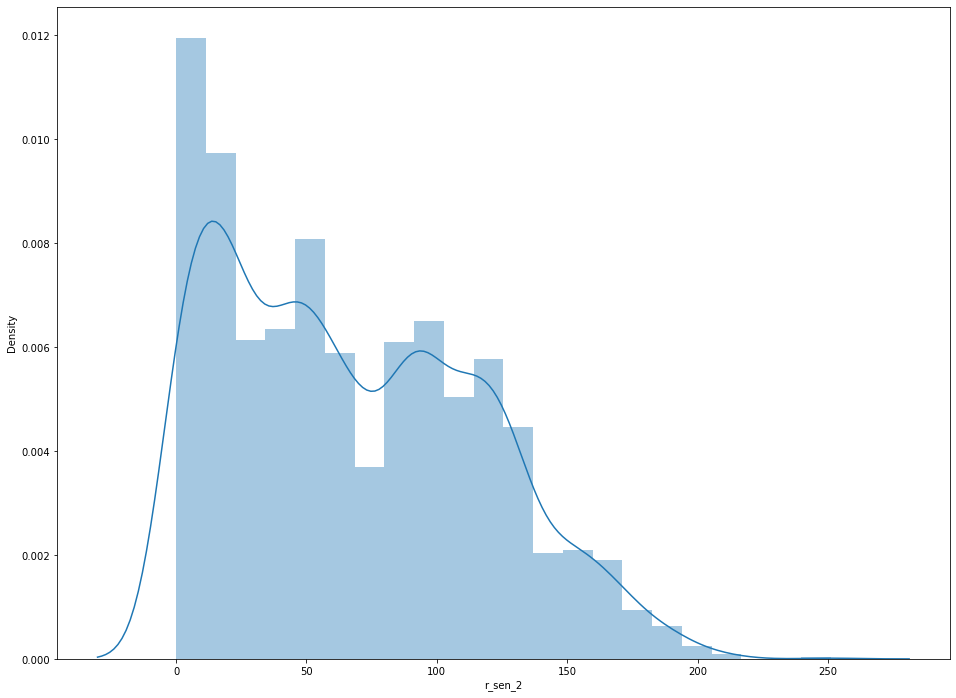

In [13]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df_d['r_sen_2'], hist=True,ax=ax)
plt.show()

## Data processing

In [14]:
def ds_make(df,y_col,win=20,md=False):    
    x, y = [], []
    for i in range(int(len(df)-win-1)):
        a = df.loc[i:(i+win)-1]
        x.append(a)
        if md:
            y.append(df.loc[i+win,['avg_sen_2','std_sen_2']])
        else:
            y.append([df.loc[i+win,'avg_sen_2']])
    return np.array(x), np.array(y)

In [15]:
df_d.drop(['datetime'],axis=1,inplace=True)

df_d.loc[:,'last_water'] = df_d.loc[:,'last_water'].astype(int)/10000000000

#scale down for computing
scaler = MinMaxScaler(feature_range=(0,1))
for col in ['r_sen_2','avg_sen_2','std_sen_2','last_water','dow']:
    df_d.loc[:,col] = scaler.fit_transform(df_d[col].values.reshape(-1,1))

df_d.to_feather(DATAPATH / 'sen_aggre_final.feather')    
df_d.head()

,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,0.0,0.0,0.0,0.487403,0.333333
1,0.0,0.0,0.0,0.537555,0.500000
2,0.0,0.0,0.0,0.587757,0.500000
3,0.0,0.0,0.0,0.637910,0.666667
4,0.0,0.0,0.0,0.688062,0.666667


## Data loader

In [16]:
class Dataset(Dataset):
    def __init__(self, data, labels):
#         super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
df_d = pd.read_feather(DATAPATH / 'sen_aggre_final.feather')

# split into DL data
win = 10
xs, ys = ds_make(df_d,"r_sen_2",win=win,md=md)
xs_t = []
for lookback in xs:
    xs_o = []
    for obs in lookback:
        for item in obs:
            xs_o.append(item)
    xs_t.append(xs_o)

In [18]:
trn_x, val_x, trn_y, val_y = train_test_split(xs,ys, test_size=0.2)

In [19]:
trn_ds = Dataset(trn_x, trn_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs)

## Model

In [46]:
class LinBench(nn.Module):
    def __init__(self, thicc, wide, out=1, dense=False):
        super().__init__()
        self.thicc = thicc          #num layers
        self.wide = wide            #num neuron
        self.out = out
        self.dense = dense
        
        self.layers = nn.ModuleList()
        
        self.layers.append(StdLinear(win*5, self.wide))
        for i in range(self.thicc-2):
            self.layers.append(StdLinear(self.wide,self.wide))
        self.layers.append(StdLinear(self.wide,self.out))
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

In [21]:
# class ConvLin(nn.Module):
#     def __init__(self, thicc, wide, out=1, dense=False):
#         super().__init__()
#         self.thicc = thicc          #num layers
#         self.wide = wide            #num neuron
#         self.out = out
#         self.dense = dense
        
#         self.layers = nn.ModuleList()
    
#         self.layers.append(StdCov(bs,self.wide,))
#         for i in range(self.thicc-1):
#             self.layers.append(StdConv(self.wide,self.wide))
#         self.layers.append(StdLinear(self.wide,self.out,act='tanh'))
        
#     def forward(self, x):
#         for i in range(self.thicc):
#             x = self.layers[i](x)
#         return x

In [22]:
f = 2
s = 1
p=0
w=5
# (f-1)/(s+1)
((w - f * 2*p)/s) + 1

6.0

In [23]:
# q = StdConv(10,)

In [24]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10.7}" * len(values)
    values = [epoch,*values] 
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, f'../data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')
names = ["ep / it","trn_loss","val_loss"]
layout = "{!s:10} " * len(names)

In [25]:
nets = [LinBench(5, 50)]

In [48]:
lay=5
nets = []
num_hid = [100,50,25,10]

for i in range(len(num_hid)):
    nets.append(LinBench(lay,num_hid[i]).cuda())

if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 2e-4
loss = nn.MSELoss()
optims = [torch.optim.Adam(net.parameters(), lr=lr) for net in nets]
scheds = [CyclicLR(optims[i], lr, mode='triangular2', step_size=len(trn_ds)//4) for i, net in enumerate(nets)]
window = 200
    
# def make_net(arch, layers):
#     if arch == 'lin':
#         net = LinBench(layers,win*5)
#     elif arch == 'conv':
#         net = 
        
    
    
#     if use_cuda:
#         nets = [net.cuda() for _,net in nets if single else net.cuda()]
#     #     net.cuda()
#         dtype = torch.cuda.FloatTensor
#     else:
#         dtype = torch.FloatTensor
    
#     return nets

In [50]:
def train(nets,epochs):
    all_vals = []
    for q, net in enumerate(nets):
        t_ls = []
        v_ls = []
        vals = {}
        print(f'net {q}')
        print(layout.format(*names))
        for epoch in range(epochs):
            trn_it = iter(trn_dl)
            val_it = iter(val_dl)
            for i, (batch, ys) in enumerate(trn_it):
                batch = np.reshape(batch, (-1))
                ys = np.reshape(ys, (-1))
                batch = batch.type(dtype)
                ys = ys.type(dtype)

                net.train()
                scheds[q].batch_step()
                optims[q].zero_grad()
                pred = net(batch)
                ls = torch.sqrt(loss(pred, ys))

                ls.backward()
                optims[q].step()

                t_ls.append(ls.item())

                if i % window == 0:
                    net.eval()
                    with torch.no_grad():
                        v_bat, v_ys = next(val_it)
                        v_bat = np.reshape(v_bat,(-1))
                        v_ys = np.reshape(v_ys,(-1))
                        v_bat = v_bat.type(dtype)
                        v_ys = v_ys.type(dtype)

                        v = net(v_bat)
                        v_loss = torch.sqrt(loss(v, v_ys))
                        v_ls.append(v_loss.item())

                    vals[epoch]= [np.mean(t_ls[-window:]), v_ls[-1]]
                    print_stats(f'{epoch+1} / {i+1}', vals[epoch], 4)
        all_vals.append([vals,t_ls,v_ls])
    return all_vals

In [51]:
vals = train(nets,10)

net 0
ep / it    trn_loss   val_loss   
  1 / 1    0.03119    0.13706   
 1 / 201   0.10744    0.13585   
 1 / 401   0.07479    0.04788   
 1 / 601   0.10399    0.04946   
 1 / 801   0.05150    0.08424   
 1 / 1001  0.03361    0.05962   
 1 / 1201  0.01821    0.00741   
 1 / 1401  0.01592    0.01008   
 1 / 1601  0.03425    0.00336   
 1 / 1801  0.03570    0.01853   
 1 / 2001  0.01730    0.00290   
 1 / 2201  0.02465    0.0       
  2 / 1    0.01755    0.01144   
 2 / 201   0.01490    0.00329   
 2 / 401   0.01282    0.02087   
 2 / 601   0.01489    0.02715   
 2 / 801   0.01489    0.00889   
 2 / 1001  0.00904    0.01006   
 2 / 1201  0.00733    0.00328   
 2 / 1401  0.00785    0.00314   
 2 / 1601  0.01353    0.00429   
 2 / 1801  0.01817    0.05402   
 2 / 2001  0.01275    0.00554   
 2 / 2201  0.00947    0.0       
  3 / 1    0.00737    0.00052   
 3 / 201   0.00662    0.00082   
 3 / 401   0.00670    0.00906   
 3 / 601   0.00981    0.00491   
 3 / 801   0.00688    0.00698   
 3 

 8 / 201   0.29438    0.24151   
 8 / 401   0.30780    0.46760   
 8 / 601   0.31254    0.27412   
 8 / 801   0.31637    0.17849   
 8 / 1001  0.29546    0.39048   
 8 / 1201  0.28668    0.26046   
 8 / 1401  0.31001    0.13001   
 8 / 1601  0.28434    0.09651   
 8 / 1801  0.27998    0.53680   
 8 / 2001  0.33577    0.51740   
 8 / 2201  0.31345    0.0       
  9 / 1    0.30430    0.18025   
 9 / 201   0.29833    0.24151   
 9 / 401   0.31081    0.46760   
 9 / 601   0.30948    0.27412   
 9 / 801   0.28837    0.17849   
 9 / 1001  0.30983    0.39048   
 9 / 1201  0.32522    0.26046   
 9 / 1401  0.29129    0.13001   
 9 / 1601  0.31570    0.09651   
 9 / 1801  0.30226    0.53680   
 9 / 2001  0.29734    0.51740   
 9 / 2201  0.29287    0.0       
  10 / 1   0.28142    0.18025   
 10 / 201  0.30250    0.24151   
 10 / 401  0.30301    0.46760   
 10 / 601  0.31158    0.27412   
 10 / 801  0.27033    0.17849   
10 / 1001  0.30344    0.39048   
10 / 1201  0.32942    0.26046   
10 / 1401 

In [34]:
vals[0][1]

[0.48721736669540405,
 0.5683892369270325,
 0.11862926185131073,
 0.01779395341873169,
 0.42859822511672974,
 8.911453187465668e-05,
 0.02007630281150341,
 0.646567165851593,
 0.7892565727233887,
 0.4464895725250244,
 0.5206614136695862,
 0.45742514729499817,
 0.17578758299350739,
 0.01321525126695633,
 0.6003601551055908,
 0.6281291842460632,
 0.05343528464436531,
 0.02738979458808899,
 0.4675416350364685,
 0.11696063727140427,
 0.3594815731048584,
 0.022027190774679184,
 0.19782045483589172,
 0.1029098778963089,
 0.09927217662334442,
 0.026301942765712738,
 0.10418389737606049,
 0.3372533619403839,
 0.003851749002933502,
 0.14104050397872925,
 0.05970504879951477,
 0.07655175030231476,
 0.05583462119102478,
 0.3587157726287842,
 0.05549592524766922,
 0.014405250549316406,
 0.24671974778175354,
 0.2919069528579712,
 0.12452410161495209,
 0.128261998295784,
 0.13389384746551514,
 0.16192874312400818,
 0.2555711269378662,
 0.12088409066200256,
 0.05673623085021973,
 0.012542426586151123

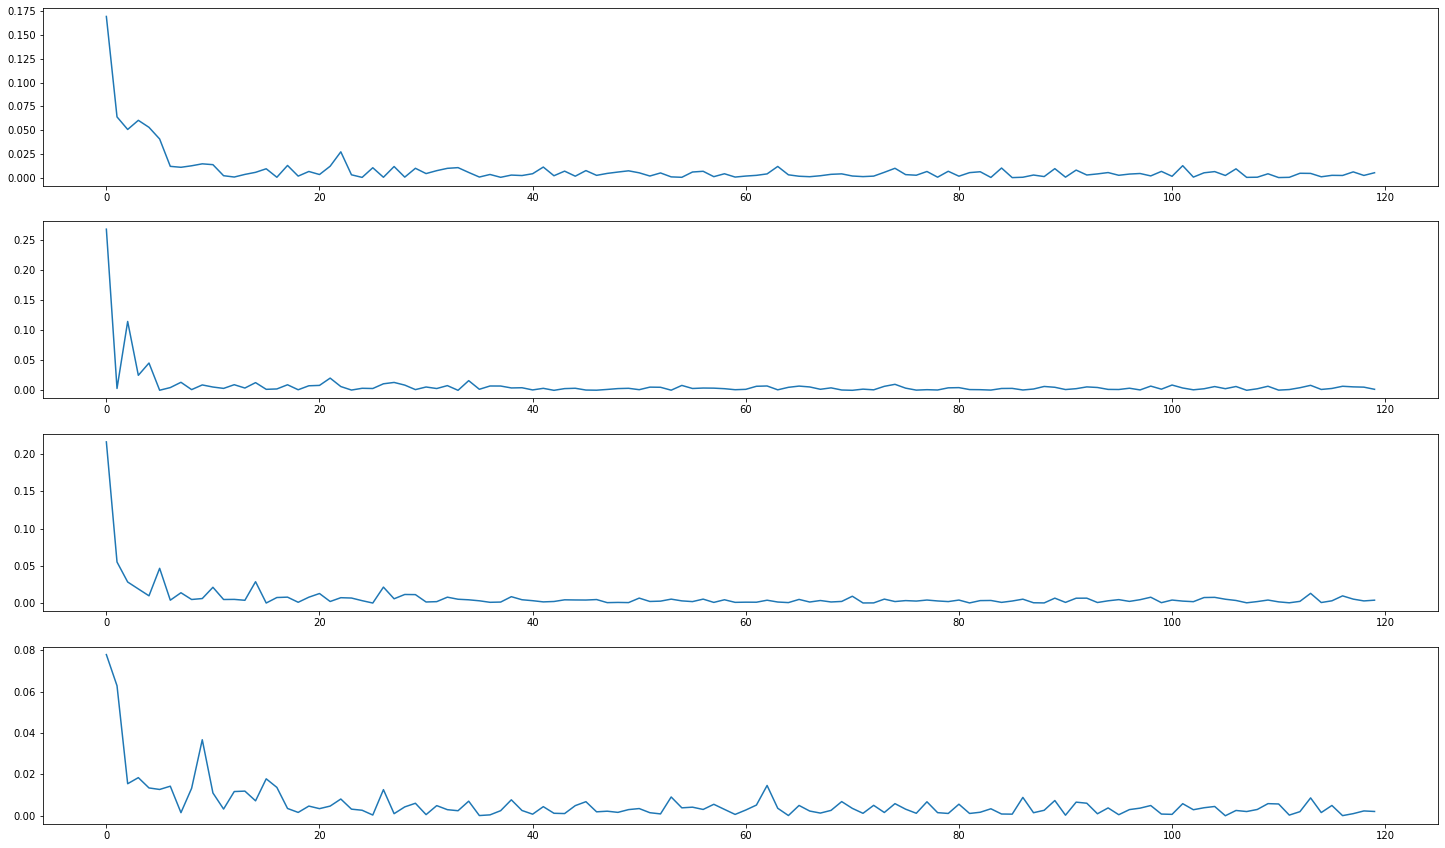

In [36]:
fig, ax = plt.subplots(len(num_hid),figsize=[25,15])
for i, ls in enumerate(vals):
    ax[i].plot(ls[2])
plt.show()

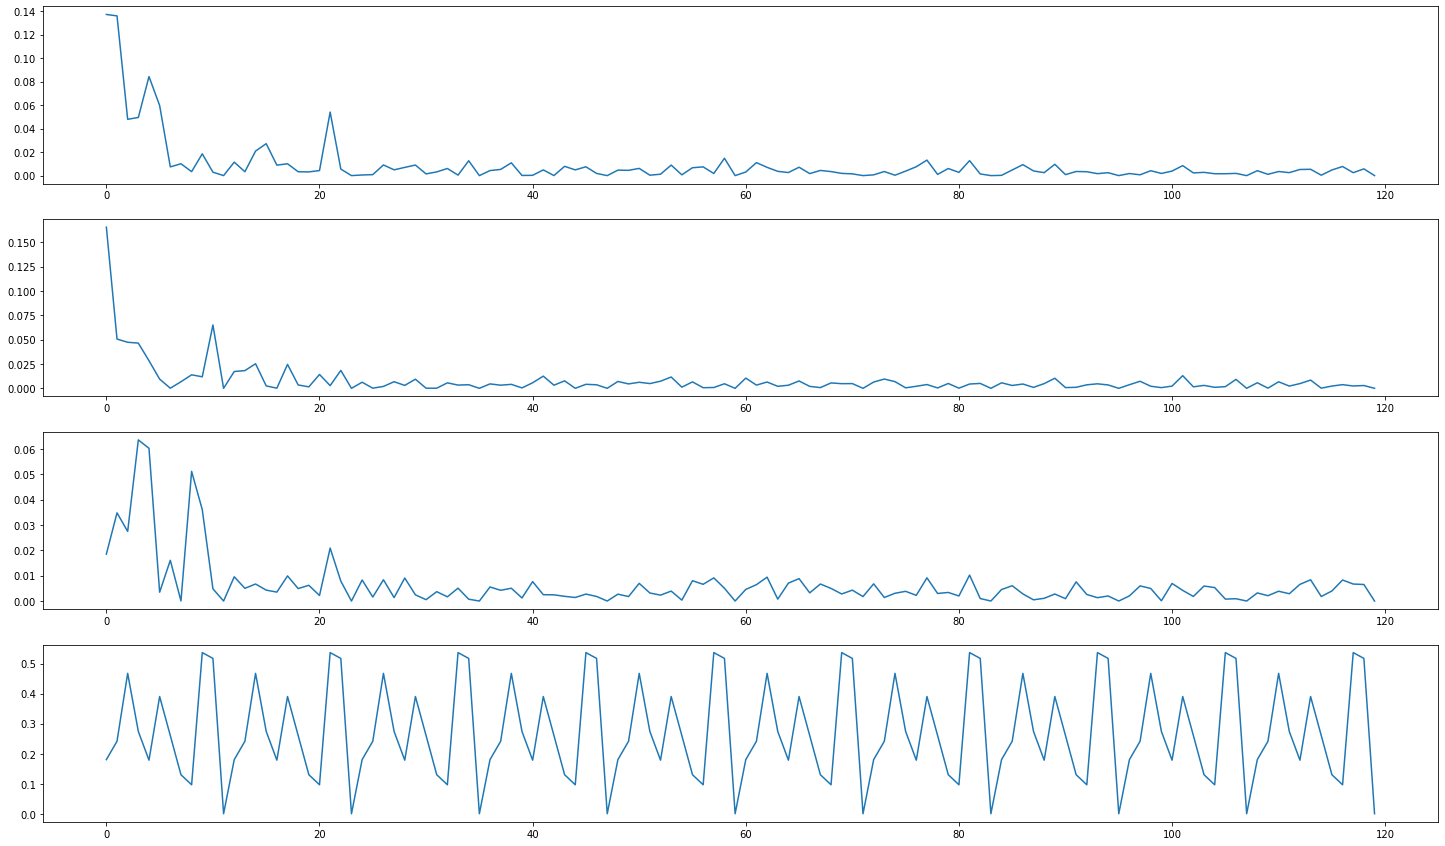

In [52]:
fig, ax = plt.subplots(len(num_hid),figsize=[25,15])
for i, ls in enumerate(vals):
    ax[i].plot(ls[2])
plt.show()

In [53]:
trn_it = iter(trn_dl)
batch, ys = next(trn_it)
batch = np.reshape(batch,(-1))
batch = batch.type(dtype)
ys = ys.type(dtype)
for i in range(len(num_hid)):
    pred = nets[i](batch)
    print(pred)
print(ys)

tensor([0.1215], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([0.1252], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([0.1242], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([0.], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[0.1225]], device='cuda:0')


In [54]:
vls = []
for i, net in enumerate(nets):
    val_it = iter(val_dl)
    v = []
    v_ys = []
    net.eval()
    for batch in range(len(val_dl)//bs):
        with torch.no_grad():
            v_bat, v_y = next(val_it)
            v_bat = np.reshape(v_bat,(-1))
            v_y = np.reshape(v_y,(-1))
            v_bat = v_bat.type(dtype)

            v.append(net(v_bat)[0].item())
            v_ys.append(v_y)
    vls.append([v,v_ys])

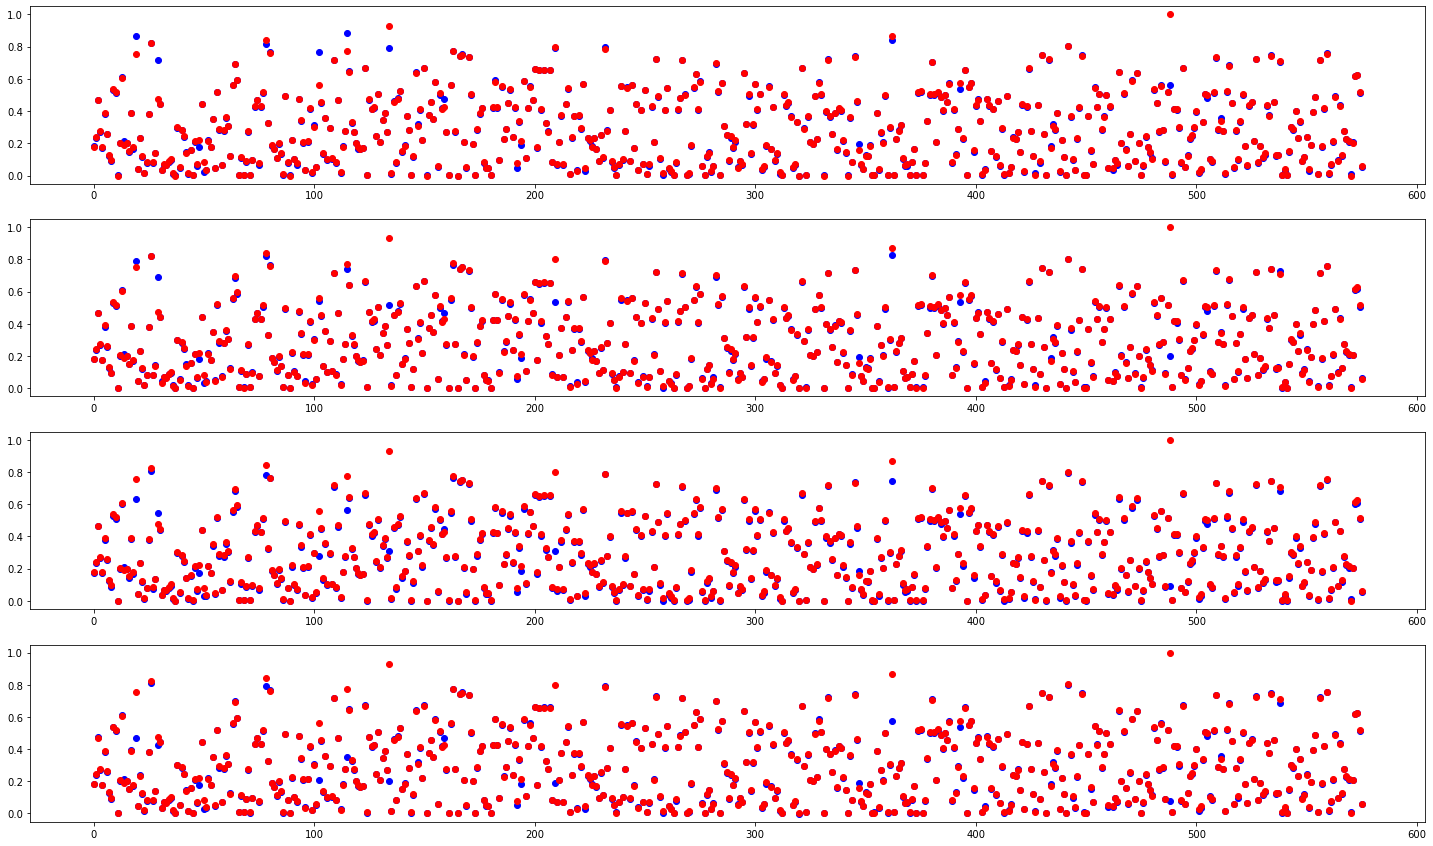

In [44]:
fig, ax = plt.subplots(len(nets),figsize=[25,15])
for i, ls in enumerate(vls):
    ax[i].plot(ls[0],'bo')
    ax[i].plot(ls[1],'ro')
plt.show()

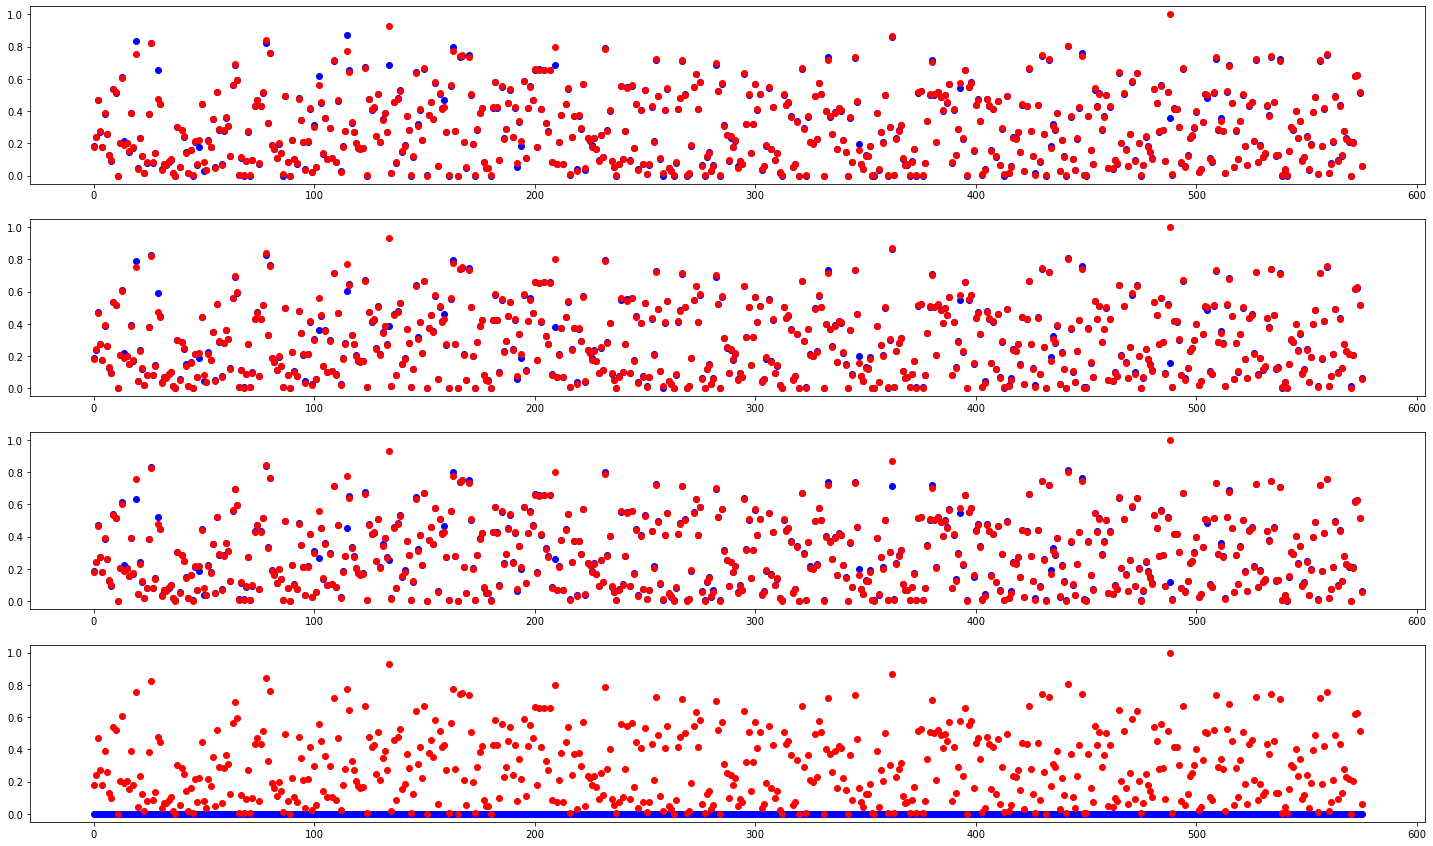

In [55]:
fig, ax = plt.subplots(len(nets),figsize=[25,15])
for i, ls in enumerate(vls):
    ax[i].plot(ls[0],'bo')
    ax[i].plot(ls[1],'ro')
plt.show()

Reference


https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205

In [ ]:
torch.save(net.state_dict(),DATAPATH / 'checks' / f'lin_{lay}_balanced.pt')